# Introduction

Notebook to analyze the **False Positive** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner import tc_br_strat_runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
vol_strat_runner = tc_br_strat_runner.TC_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

lsi_model_4 = vol_strat_runner.get_lsi_model()
lda_model_4 = vol_strat_runner.get_lda_model()
bm25_model_4 = vol_strat_runner.get_bm25_model()
w2v_model_4 = vol_strat_runner.get_word2vec_model()

oracle = vol_strat_runner.get_oracle()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

OracleVolunteers.shape: (195, 91)
TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_10_cosine_0.0,33.08,23.46,26.09,precision recall fscore ...,0.0,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_10_cosine_0.1,33.08,23.46,26.09,precision recall fscore ...,0.1,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_10_cosine_0.2,33.08,23.46,26.09,precision recall fscore ...,0.2,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_10_cosine_0.3,33.08,23.46,26.09,precision recall fscore ...,0.3,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_10_cosine_0.4,32.99,23.28,25.97,precision recall fscore ...,0.4,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

### Min Precision

model
bm25          14.04
lda            6.94
lsi            9.07
wordvector     6.21
Name: perc_precision, dtype: float64



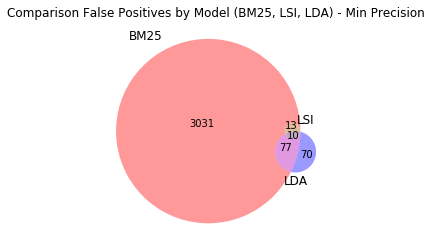

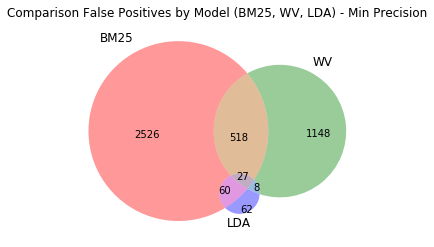

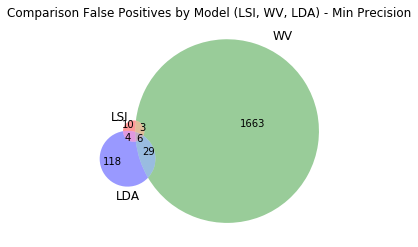

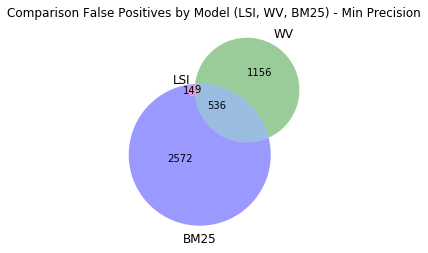

In [6]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 2516


LSI Exclusive FP:
len(lsi_exc_set): 0


LDA Exclusive FP:
len(lda_exc_set): 62


WV Exclusive FP:
len(wv_exc_set): 1148


##### Word Clouds

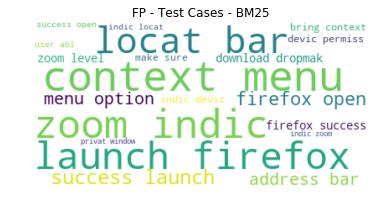

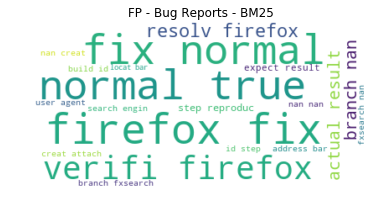

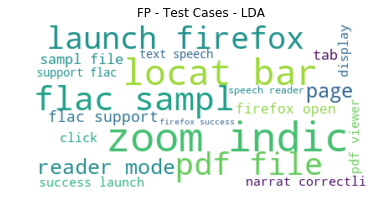

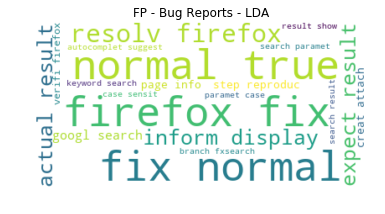

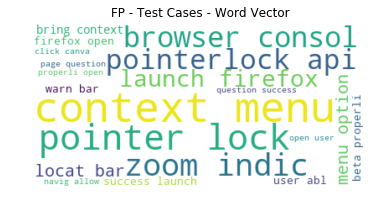

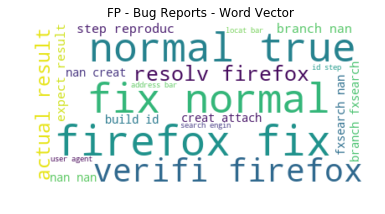

In [8]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

#aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
#                                     wc_tc_title="FP - Test Cases - LSI",
#                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [9]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 23
LDA FP Amount: 157
BM25 FP Amount: 3131
WV FP Amount: 1701


##### Detailing Features for Exclusive Sets

In [10]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_99_TRG,Context Menu,BR_1335992_SRC,Search with default search engine stops working
1,TC_177_TRG,FLAC support,BR_1297336_SRC,Device permission gone from the permission dropdown after detaching the tab to a new window
2,TC_119_TRG,Text to Speech in Reader Mode,BR_1345687_SRC,[Regression] Clicking on audioVideoButton / sharing-icon don't work when typed on urlbar
3,TC_65_TRG,PDF Viewer,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
4,TC_193_TRG,Indicator for device permissions,BR_1281190_SRC,Keep collecting telemetry for Permissions Notifications until version 55
5,TC_183_TRG,Indicator for device permissions,BR_1287384_SRC,Incorrect alignment of Summary section in Downloads panel
6,TC_43_TRG,APZ - Async Scrolling,BR_1267501_SRC,New Private Browsing start-page overflows off the *left side of the window* (making content unscrollable) for small window sizes
7,TC_157_TRG,Downloads Dropmaker,BR_1325902_SRC,Increase visibility of container highlight on tabs
8,TC_55_TRG,APZ - Async Scrolling,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
9,TC_158_TRG,Downloads Dropmaker,BR_1287823_SRC,[Linux] Dragging & dropping a download from the downloads panel on desktop saves a txt file


,tc,tc_feat,br,br_summary
0,TC_177_TRG,FLAC support,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
1,TC_66_TRG,PDF Viewer,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"
2,TC_31_TRG,Windows Child Mode,BR_1287748_SRC,"Syncing away from lwtheme updates internal state / add-on manager UI, but not the actual browser"
3,TC_120_TRG,WebGL Compatibility,BR_1313290_SRC,Use browser specific message manager in `SocialShare.sharePage`
4,TC_147_TRG,Zoom Indicator,BR_1320557_SRC,"No security information displayed for a specific website, using a specific Firefox profile"
5,TC_175_TRG,FLAC support,BR_1323211_SRC,Change Sync datatype label from Tabs to Open tabs
6,TC_179_TRG,FLAC support,BR_1267501_SRC,New Private Browsing start-page overflows off the *left side of the window* (making content unscrollable) for small window sizes
7,TC_176_TRG,FLAC support,BR_1323211_SRC,Change Sync datatype label from Tabs to Open tabs
8,TC_69_TRG,PDF Viewer,BR_1287748_SRC,"Syncing away from lwtheme updates internal state / add-on manager UI, but not the actual browser"
9,TC_174_TRG,FLAC support,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down


,tc,tc_feat,br,br_summary


,tc,tc_feat,br,br_summary
0,TC_89_TRG,Context Menu,BR_1352539_SRC,Move defaultenginename pref setting into list.json
1,TC_27_TRG,Windows Child Mode,BR_1297686_SRC,"When multiple desktop files support the same protocol scheme, only one of them is listed"
2,TC_107_TRG,Windows 10 Compatibility,BR_1344446_SRC,tab bar scroll buttons are too narrow for touchscreen use
3,TC_36_TRG,Windows Child Mode,BR_1301784_SRC,Pref-off Search Reset UI for 50 beta
4,TC_130_TRG,Pointer Lock API,BR_1316126_SRC,`_endRemoveTab` can get stuck in an infinite loop
5,TC_159_TRG,Downloads Dropmaker,BR_1451475_SRC,Renew scalar browser.engagement.restored_pinned_tabs_count
6,TC_107_TRG,Windows 10 Compatibility,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
7,TC_185_TRG,Indicator for device permissions,BR_1248268_SRC,"Unable to disable ""Recently bookmarked"""
8,TC_126_TRG,Pointer Lock API,BR_1344446_SRC,tab bar scroll buttons are too narrow for touchscreen use
9,TC_38_TRG,APZ - Async Scrolling,BR_1296322_SRC,X button is vertically misaligned on the permission dropdown


#### Max Precision

model
bm25          21.21
lda           20.03
lsi           33.80
wordvector     6.85
Name: perc_precision, dtype: float64



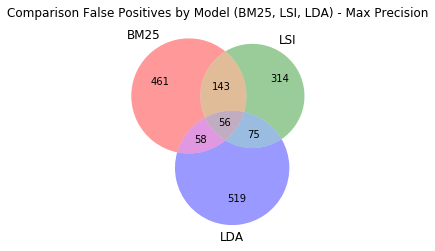

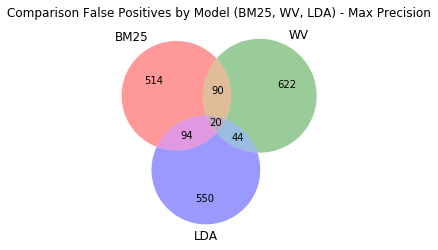

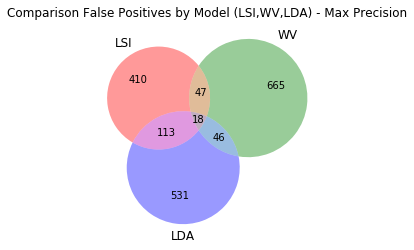

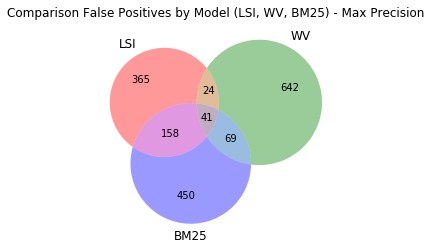

In [11]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [12]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 400


LSI Exclusive FP:
len(lsi_exc_set): 296


LDA Exclusive FP:
len(lda_exc_set): 481


WV Exclusive FP:
len(wv_exc_set): 604


##### Word Clouds

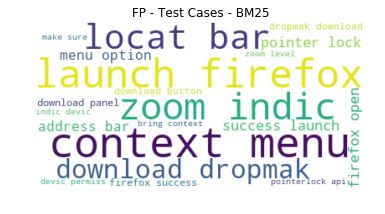

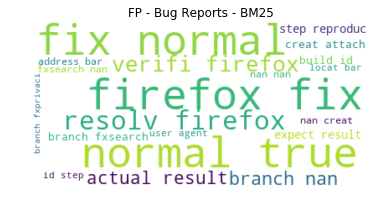

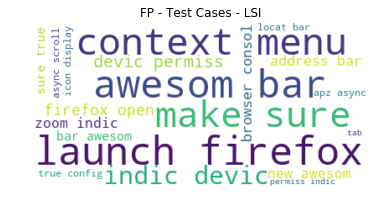

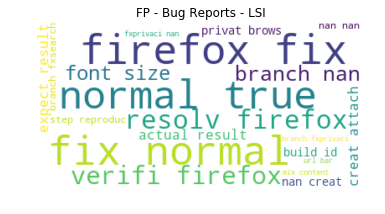

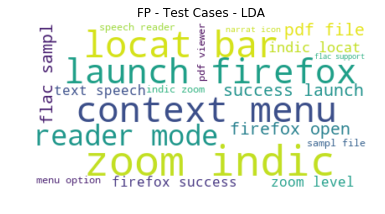

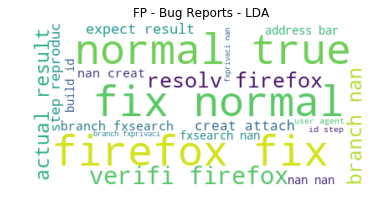

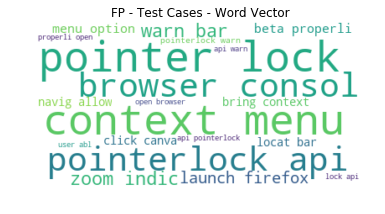

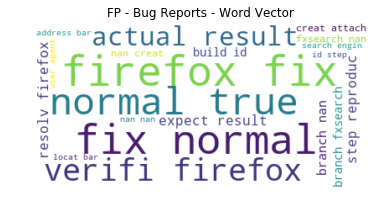

In [13]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LSI",
                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [14]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 588
LDA FP Amount: 708
BM25 FP Amount: 718
WV FP Amount: 776


##### Detailing Features for Exclusive Sets

In [15]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_181_TRG,Indicator for device permissions,BR_1305676_SRC,In some circumstances passive mixed content indicator will override active mixed content indicator
1,TC_36_TRG,Windows Child Mode,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"
2,TC_45_TRG,APZ - Async Scrolling,BR_1296366_SRC,"Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
3,TC_33_TRG,Windows Child Mode,BR_1296861_SRC,[control center] Don't hardcode colors for the permission status and permission removal button
4,TC_27_TRG,Windows Child Mode,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
5,TC_187_TRG,Indicator for device permissions,BR_1335992_SRC,Search with default search engine stops working
6,TC_162_TRG,Downloads Dropmaker,BR_1278388_SRC,Permafailing on the change to firefox50: browser_permissions_urlFieldHidden.jsuncaught exception - Error: Expected one argument at showNotificationExceptions@content.js:136:5
7,TC_88_TRG,Context Menu,BR_1352539_SRC,Move defaultenginename pref setting into list.json
8,TC_29_TRG,Windows Child Mode,BR_1352539_SRC,Move defaultenginename pref setting into list.json
9,TC_161_TRG,Downloads Dropmaker,BR_1289240_SRC,"Services.search.getDefaultEngines() empty, search engine reset triggered when using a language pack"


,tc,tc_feat,br,br_summary
0,TC_178_TRG,FLAC support,BR_1269348_SRC,Show last sync date tooltip on Synced Tabs sidebar device names
1,TC_148_TRG,Zoom Indicator,BR_1296861_SRC,[control center] Don't hardcode colors for the permission status and permission removal button
2,TC_71_TRG,PDF Viewer,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
3,TC_20_TRG,New Awesome Bar,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu
4,TC_193_TRG,Indicator for device permissions,BR_1281190_SRC,Keep collecting telemetry for Permissions Notifications until version 55
5,TC_103_TRG,Context Menu,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"
6,TC_114_TRG,Text to Speech in Reader Mode,BR_1278388_SRC,Permafailing on the change to firefox50: browser_permissions_urlFieldHidden.jsuncaught exception - Error: Expected one argument at showNotificationExceptions@content.js:136:5
7,TC_201_TRG,Zoom Indicator,BR_1337682_SRC,using ctrl / shift + enter seems to save the URL to a hidden clipboard that populates when hitting enter (hard to describe).
8,TC_113_TRG,Text to Speech in Reader Mode,BR_1267480_SRC,Intermittent browser/components/preferences/in-content/tests/browser_security.jsThis test exceeded the timeout threshold. It should be rewritten or split up.
9,TC_65_TRG,PDF Viewer,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"


,tc,tc_feat,br,br_summary
0,TC_25_TRG,New Awesome Bar,BR_1320557_SRC,"No security information displayed for a specific website, using a specific Firefox profile"
1,TC_149_TRG,Zoom Indicator,BR_1293308_SRC,System font setting respected by location bar but ignored by location bar's autocomplete drop-down list
2,TC_198_TRG,Zoom Indicator,BR_1293308_SRC,System font setting respected by location bar but ignored by location bar's autocomplete drop-down list
3,TC_124_TRG,Web Page Renderization,BR_1302468_SRC,Firefox Beta reports channel as 'release' when build is RC due to use of Services.appinfo.defaultUpdateChannel
4,TC_43_TRG,APZ - Async Scrolling,BR_1270274_SRC,"Intermittent browser_share.jsuncaught exception - Error: operation not possible on dead CPOW atTest timed outFound a tabSocialUI is not enabled - Got true, expected false"
5,TC_174_TRG,FLAC support,BR_1285041_SRC,Investigate Chrome profile migration importing history when chrome is running
6,TC_44_TRG,APZ - Async Scrolling,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"
7,TC_182_TRG,Indicator for device permissions,BR_1305737_SRC,Change notification displayed when an incoming tab can't determine the device name it came from
8,TC_189_TRG,Indicator for device permissions,BR_1297336_SRC,Device permission gone from the permission dropdown after detaching the tab to a new window
9,TC_169_TRG,Downloads Dropmaker,BR_1287823_SRC,[Linux] Dragging & dropping a download from the downloads panel on desktop saves a txt file


,tc,tc_feat,br,br_summary
0,TC_130_TRG,Pointer Lock API,BR_1316126_SRC,`_endRemoveTab` can get stuck in an infinite loop
1,TC_107_TRG,Windows 10 Compatibility,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
2,TC_38_TRG,APZ - Async Scrolling,BR_1296322_SRC,X button is vertically misaligned on the permission dropdown
3,TC_136_TRG,WebM EME support for Widevine,BR_1283542_SRC,Automigration from Chrome is broken
4,TC_129_TRG,Pointer Lock API,BR_1303339_SRC,The animated sharing icons of the control center panel never go to full opacity
5,TC_132_TRG,Pointer Lock API,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
6,TC_99_TRG,Context Menu,BR_1314643_SRC,[One-off searches] Changing the default search engine from Search bar does not work first time
7,TC_130_TRG,Pointer Lock API,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
8,TC_135_TRG,Pointer Lock API,BR_1248268_SRC,"Unable to disable ""Recently bookmarked"""
9,TC_129_TRG,Pointer Lock API,BR_1281493_SRC,"Identity popup sometimes doesn't display EV/DV site identity above ""Secure connection"" label"


#### Min Recall

model
bm25          14.20
lda            2.59
lsi            1.88
wordvector     3.61
Name: perc_recall, dtype: float64



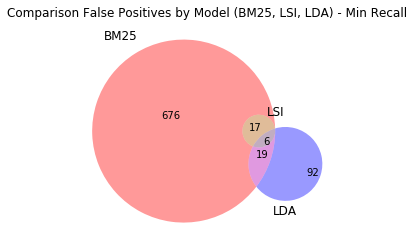

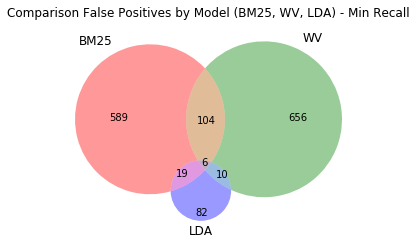

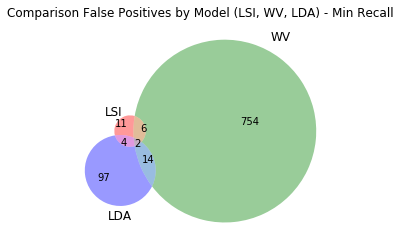

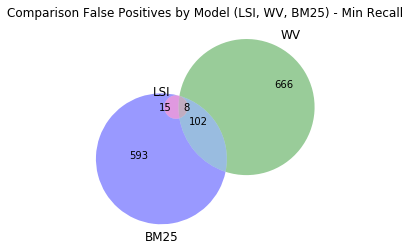

In [16]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [17]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1313778_SRC'),
 ('TC_100_TRG', 'BR_1325902_SRC'),
 ('TC_101_TRG', 'BR_1301421_SRC'),
 ('TC_101_TRG', 'BR_1313290_SRC'),
 ('TC_101_TRG', 'BR_1314643_SRC'),
 ('TC_101_TRG', 'BR_1330745_SRC'),
 ('TC_105_TRG', 'BR_1281190_SRC'),
 ('TC_105_TRG', 'BR_1313969_SRC'),
 ('TC_106_TRG', 'BR_1267501_SRC'),
 ('TC_106_TRG', 'BR_1269485_SRC'),
 ('TC_106_TRG', 'BR_1297976_SRC'),
 ('TC_107_TRG', 'BR_1281190_SRC'),
 ('TC_108_TRG', 'BR_1271607_SRC'),
 ('TC_108_TRG', 'BR_1281190_SRC'),
 ('TC_108_TRG', 'BR_1328913_SRC'),
 ('TC_109_TRG', 'BR_1271607_SRC'),
 ('TC_109_TRG', 'BR_1276120_SRC'),
 ('TC_109_TRG', 'BR_1296366_SRC'),
 ('TC_109_TRG', 'BR_1311998_SRC'),
 ('TC_109_TRG', 'BR_1313778_SRC'),
 ('TC_109_TRG', 'BR_1313969_SRC'),
 ('TC_109_TRG', 'BR_1316126_SRC'),
 ('TC_109_TRG', 'BR_1328913_SRC'),
 ('TC_110_TRG', 'BR_1357458_SRC'),
 ('TC_111_TRG', 'BR_1301784_SRC'),
 ('TC_111_TRG', 'BR_1352539_SRC'),
 ('TC_111_TRG', 'BR_1357085_SRC'),
 ('TC_111_TRG', 'BR_1430603_SRC'),
 ('TC_112_TRG', 'BR_



LSI Exclusive FP:


set()



LDA Exclusive FP:


{('TC_112_TRG', 'BR_1297374_SRC'),
 ('TC_113_TRG', 'BR_1297976_SRC'),
 ('TC_113_TRG', 'BR_1312018_SRC'),
 ('TC_113_TRG', 'BR_1353831_SRC'),
 ('TC_114_TRG', 'BR_1312018_SRC'),
 ('TC_114_TRG', 'BR_1353831_SRC'),
 ('TC_115_TRG', 'BR_1278388_SRC'),
 ('TC_116_TRG', 'BR_1312018_SRC'),
 ('TC_117_TRG', 'BR_1312018_SRC'),
 ('TC_117_TRG', 'BR_1353831_SRC'),
 ('TC_118_TRG', 'BR_1278388_SRC'),
 ('TC_118_TRG', 'BR_1297374_SRC'),
 ('TC_118_TRG', 'BR_1353831_SRC'),
 ('TC_119_TRG', 'BR_1353831_SRC'),
 ('TC_120_TRG', 'BR_1287748_SRC'),
 ('TC_120_TRG', 'BR_1313290_SRC'),
 ('TC_120_TRG', 'BR_1357085_SRC'),
 ('TC_122_TRG', 'BR_1287748_SRC'),
 ('TC_122_TRG', 'BR_1313290_SRC'),
 ('TC_144_TRG', 'BR_1320557_SRC'),
 ('TC_145_TRG', 'BR_1320557_SRC'),
 ('TC_149_TRG', 'BR_1320557_SRC'),
 ('TC_14_TRG', 'BR_1267480_SRC'),
 ('TC_150_TRG', 'BR_1320557_SRC'),
 ('TC_151_TRG', 'BR_1320557_SRC'),
 ('TC_162_TRG', 'BR_1283542_SRC'),
 ('TC_166_TRG', 'BR_1257087_SRC'),
 ('TC_166_TRG', 'BR_1287823_SRC'),
 ('TC_174_TRG', 'BR_1



WV Exclusive FP:


{('TC_100_TRG', 'BR_1267501_SRC'),
 ('TC_100_TRG', 'BR_1269348_SRC'),
 ('TC_100_TRG', 'BR_1269485_SRC'),
 ('TC_100_TRG', 'BR_1282759_SRC'),
 ('TC_100_TRG', 'BR_1285328_SRC'),
 ('TC_100_TRG', 'BR_1287384_SRC'),
 ('TC_100_TRG', 'BR_1292566_SRC'),
 ('TC_100_TRG', 'BR_1294887_SRC'),
 ('TC_100_TRG', 'BR_1297686_SRC'),
 ('TC_100_TRG', 'BR_1301056_SRC'),
 ('TC_100_TRG', 'BR_1305676_SRC'),
 ('TC_100_TRG', 'BR_1312018_SRC'),
 ('TC_100_TRG', 'BR_1313290_SRC'),
 ('TC_100_TRG', 'BR_1319119_SRC'),
 ('TC_100_TRG', 'BR_1320557_SRC'),
 ('TC_100_TRG', 'BR_1334844_SRC'),
 ('TC_100_TRG', 'BR_1335992_SRC'),
 ('TC_100_TRG', 'BR_1337682_SRC'),
 ('TC_100_TRG', 'BR_1343256_SRC'),
 ('TC_100_TRG', 'BR_1357085_SRC'),
 ('TC_100_TRG', 'BR_1408361_SRC'),
 ('TC_100_TRG', 'BR_1430603_SRC'),
 ('TC_100_TRG', 'BR_1451475_SRC'),
 ('TC_101_TRG', 'BR_1285328_SRC'),
 ('TC_101_TRG', 'BR_1430603_SRC'),
 ('TC_105_TRG', 'BR_1297976_SRC'),
 ('TC_105_TRG', 'BR_1301784_SRC'),
 ('TC_105_TRG', 'BR_1305737_SRC'),
 ('TC_106_TRG', 'BR_

#### Max Recall

model
bm25          32.54
lda           33.25
lsi           46.99
wordvector    12.62
Name: perc_recall, dtype: float64



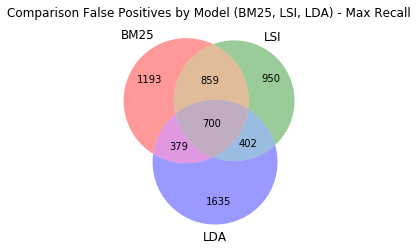

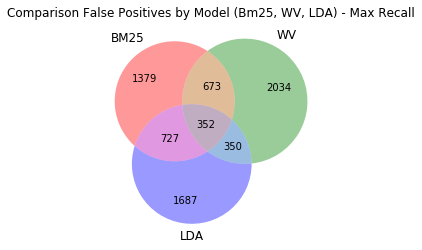

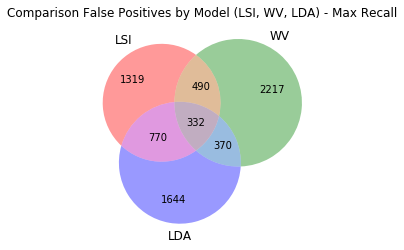

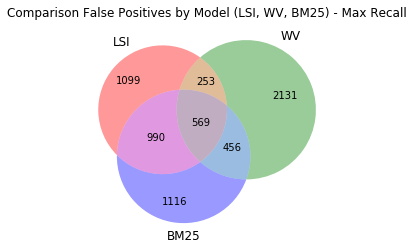

In [18]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [19]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1297976_SRC'),
 ('TC_100_TRG', 'BR_1311998_SRC'),
 ('TC_101_TRG', 'BR_1269485_SRC'),
 ('TC_101_TRG', 'BR_1287748_SRC'),
 ('TC_101_TRG', 'BR_1297686_SRC'),
 ('TC_101_TRG', 'BR_1297976_SRC'),
 ('TC_101_TRG', 'BR_1301421_SRC'),
 ('TC_101_TRG', 'BR_1301784_SRC'),
 ('TC_101_TRG', 'BR_1311998_SRC'),
 ('TC_101_TRG', 'BR_1313290_SRC'),
 ('TC_101_TRG', 'BR_1316126_SRC'),
 ('TC_101_TRG', 'BR_1408361_SRC'),
 ('TC_102_TRG', 'BR_1305676_SRC'),
 ('TC_103_TRG', 'BR_1305676_SRC'),
 ('TC_105_TRG', 'BR_1313778_SRC'),
 ('TC_106_TRG', 'BR_1287823_SRC'),
 ('TC_106_TRG', 'BR_1313778_SRC'),
 ('TC_108_TRG', 'BR_1289240_SRC'),
 ('TC_109_TRG', 'BR_1289240_SRC'),
 ('TC_109_TRG', 'BR_1294887_SRC'),
 ('TC_109_TRG', 'BR_1296366_SRC'),
 ('TC_109_TRG', 'BR_1299458_SRC'),
 ('TC_109_TRG', 'BR_1313778_SRC'),
 ('TC_109_TRG', 'BR_1323211_SRC'),
 ('TC_109_TRG', 'BR_1334844_SRC'),
 ('TC_110_TRG', 'BR_1276120_SRC'),
 ('TC_110_TRG', 'BR_1287823_SRC'),
 ('TC_110_TRG', 'BR_1290424_SRC'),
 ('TC_111_TRG', 'BR_



LSI Exclusive FP:


{('TC_102_TRG', 'BR_1283542_SRC'),
 ('TC_102_TRG', 'BR_1285041_SRC'),
 ('TC_102_TRG', 'BR_1313778_SRC'),
 ('TC_103_TRG', 'BR_1283542_SRC'),
 ('TC_103_TRG', 'BR_1285041_SRC'),
 ('TC_103_TRG', 'BR_1313778_SRC'),
 ('TC_104_TRG', 'BR_1267501_SRC'),
 ('TC_104_TRG', 'BR_1269485_SRC'),
 ('TC_104_TRG', 'BR_1276120_SRC'),
 ('TC_104_TRG', 'BR_1281190_SRC'),
 ('TC_104_TRG', 'BR_1281493_SRC'),
 ('TC_104_TRG', 'BR_1287748_SRC'),
 ('TC_104_TRG', 'BR_1297336_SRC'),
 ('TC_104_TRG', 'BR_1301784_SRC'),
 ('TC_104_TRG', 'BR_1313290_SRC'),
 ('TC_104_TRG', 'BR_1313969_SRC'),
 ('TC_104_TRG', 'BR_1318903_SRC'),
 ('TC_104_TRG', 'BR_1335538_SRC'),
 ('TC_104_TRG', 'BR_1336227_SRC'),
 ('TC_104_TRG', 'BR_1357085_SRC'),
 ('TC_105_TRG', 'BR_1267501_SRC'),
 ('TC_105_TRG', 'BR_1269485_SRC'),
 ('TC_105_TRG', 'BR_1281493_SRC'),
 ('TC_105_TRG', 'BR_1345687_SRC'),
 ('TC_106_TRG', 'BR_1276120_SRC'),
 ('TC_106_TRG', 'BR_1287384_SRC'),
 ('TC_106_TRG', 'BR_1293308_SRC'),
 ('TC_106_TRG', 'BR_1313290_SRC'),
 ('TC_106_TRG', 'BR_



LDA Exclusive FP:


{('TC_147_TRG', 'BR_1430603_SRC'),
 ('TC_148_TRG', 'BR_1339497_SRC'),
 ('TC_67_TRG', 'BR_1276120_SRC'),
 ('TC_151_TRG', 'BR_1297374_SRC'),
 ('TC_166_TRG', 'BR_1278388_SRC'),
 ('TC_90_TRG', 'BR_1285041_SRC'),
 ('TC_32_TRG', 'BR_1449700_SRC'),
 ('TC_121_TRG', 'BR_1336227_SRC'),
 ('TC_70_TRG', 'BR_1357085_SRC'),
 ('TC_178_TRG', 'BR_1432915_SRC'),
 ('TC_86_TRG', 'BR_1297686_SRC'),
 ('TC_199_TRG', 'BR_1320557_SRC'),
 ('TC_67_TRG', 'BR_1313290_SRC'),
 ('TC_121_TRG', 'BR_1293308_SRC'),
 ('TC_202_TRG', 'BR_1430603_SRC'),
 ('TC_151_TRG', 'BR_1301784_SRC'),
 ('TC_206_TRG', 'BR_1343256_SRC'),
 ('TC_120_TRG', 'BR_1291770_SRC'),
 ('TC_158_TRG', 'BR_1248267_SRC'),
 ('TC_111_TRG', 'BR_1343256_SRC'),
 ('TC_71_TRG', 'BR_1278388_SRC'),
 ('TC_98_TRG', 'BR_1295502_SRC'),
 ('TC_112_TRG', 'BR_1299458_SRC'),
 ('TC_134_TRG', 'BR_1365887_SRC'),
 ('TC_67_TRG', 'BR_1301421_SRC'),
 ('TC_148_TRG', 'BR_1281190_SRC'),
 ('TC_72_TRG', 'BR_1319119_SRC'),
 ('TC_116_TRG', 'BR_1306639_SRC'),
 ('TC_174_TRG', 'BR_1299458_SR



WV Exclusive FP:


{('TC_159_TRG', 'BR_1451475_SRC'),
 ('TC_107_TRG', 'BR_1297374_SRC'),
 ('TC_55_TRG', 'BR_1345687_SRC'),
 ('TC_151_TRG', 'BR_1270274_SRC'),
 ('TC_149_TRG', 'BR_1357458_SRC'),
 ('TC_129_TRG', 'BR_1303339_SRC'),
 ('TC_77_TRG', 'BR_1316126_SRC'),
 ('TC_38_TRG', 'BR_1309856_SRC'),
 ('TC_94_TRG', 'BR_1316126_SRC'),
 ('TC_160_TRG', 'BR_1408361_SRC'),
 ('TC_153_TRG', 'BR_1305737_SRC'),
 ('TC_186_TRG', 'BR_1285041_SRC'),
 ('TC_204_TRG', 'BR_1313969_SRC'),
 ('TC_96_TRG', 'BR_1293308_SRC'),
 ('TC_136_TRG', 'BR_1281493_SRC'),
 ('TC_131_TRG', 'BR_1344446_SRC'),
 ('TC_47_TRG', 'BR_1319919_SRC'),
 ('TC_131_TRG', 'BR_1334844_SRC'),
 ('TC_183_TRG', 'BR_1287748_SRC'),
 ('TC_129_TRG', 'BR_1289240_SRC'),
 ('TC_46_TRG', 'BR_1309856_SRC'),
 ('TC_92_TRG', 'BR_1287384_SRC'),
 ('TC_61_TRG', 'BR_1287687_SRC'),
 ('TC_162_TRG', 'BR_1319433_SRC'),
 ('TC_199_TRG', 'BR_1287687_SRC'),
 ('TC_96_TRG', 'BR_1305676_SRC'),
 ('TC_147_TRG', 'BR_1270983_SRC'),
 ('TC_131_TRG', 'BR_1365887_SRC'),
 ('TC_199_TRG', 'BR_1451475_SR

In [20]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 2911
LDA FP Amount: 3116
BM25 FP Amount: 3131
WV FP Amount: 3409
